In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import xgboost as xgb
from scipy import stats
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

Found dataset at: ..\Cleaned_marketing_campaign_dataset.csv
TESTING HYPOTHESIS FOR AWARENESS MODEL (CLICKS PREDICTION)
Loading dataset from: ..\Cleaned_marketing_campaign_dataset.csv
Dataset loaded successfully with 67896 rows
Available columns: ['campaign_item_id', 'duration', 'time', 'ext_service_id', 'ext_service_name', 'creative_id', 'creative_width', 'creative_height', 'search_tags', 'template_id', 'landing_page', 'advertiser_id', 'advertiser_name', 'network_id', 'approved_budget', 'advertiser_currency', 'channel_id', 'channel_name', 'max_bid_cpm', 'network_margin', 'campaign_budget_usd', 'impressions', 'clicks', 'stats_currency', 'currency_code', 'exchange_rate', 'media_cost_usd', 'position_in_content', 'unique_reach', 'total_reach', 'search_tag_cat', 'cmi_currency_code', 'timezone', 'weekday_cat', 'keywords', 'ctr', 'campaign_size', 'log_media_cost']
Creating a new XGBoost model for awareness for comparison
Evaluating XGBoost...
Evaluating Linear Regression...
Evaluating Mean Pr

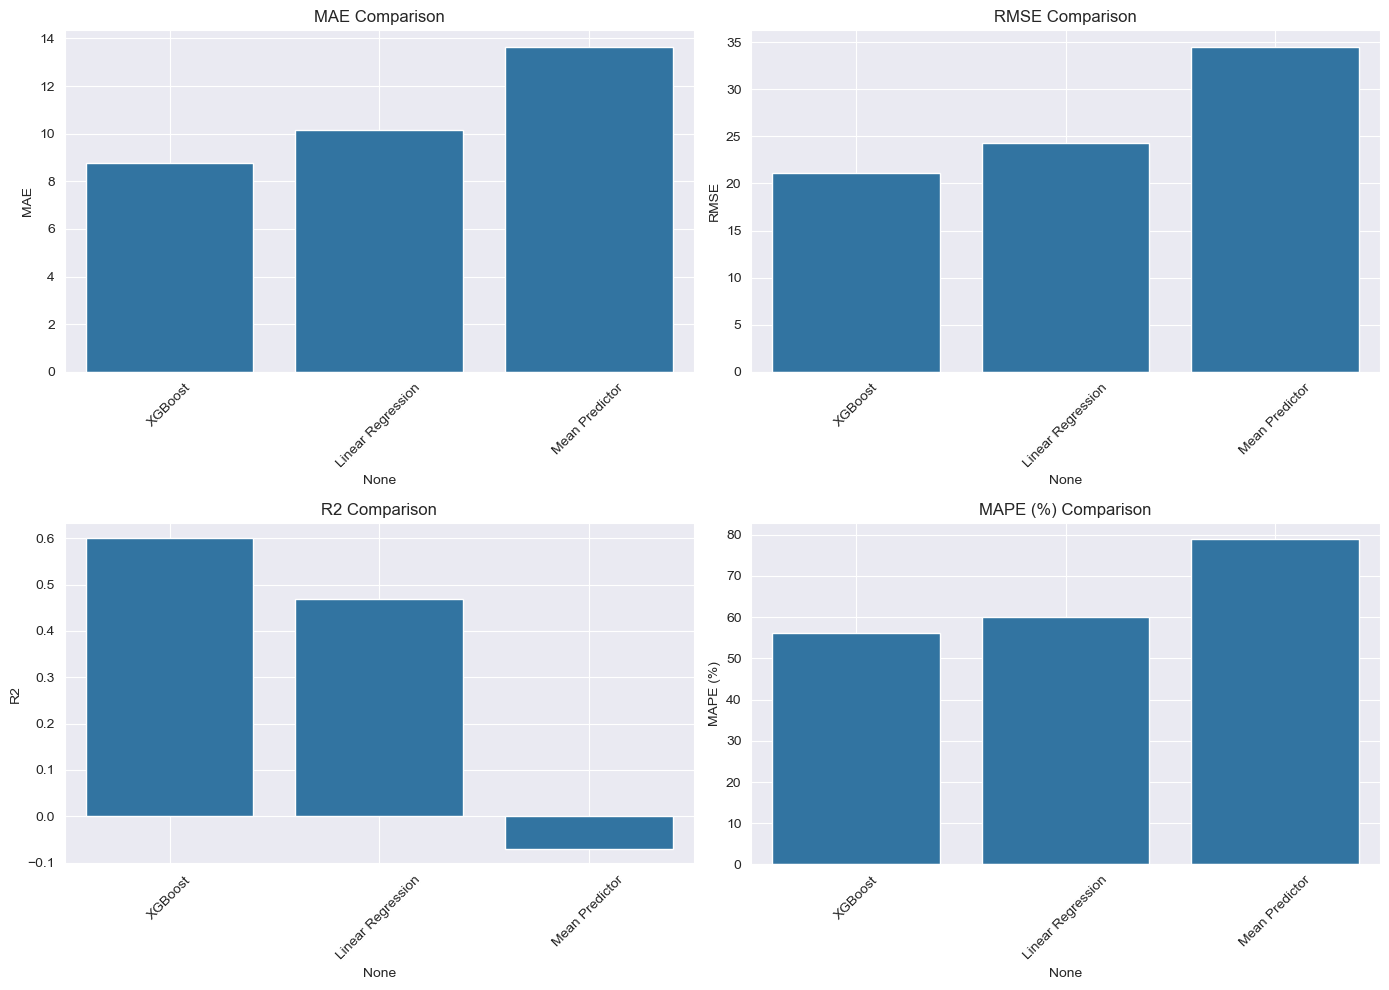



TESTING HYPOTHESIS FOR CONVERSION MODEL (IMPRESSIONS PREDICTION)
Loading dataset from: ..\Cleaned_marketing_campaign_dataset.csv
Dataset loaded successfully with 67896 rows
Available columns: ['campaign_item_id', 'duration', 'time', 'ext_service_id', 'ext_service_name', 'creative_id', 'creative_width', 'creative_height', 'search_tags', 'template_id', 'landing_page', 'advertiser_id', 'advertiser_name', 'network_id', 'approved_budget', 'advertiser_currency', 'channel_id', 'channel_name', 'max_bid_cpm', 'network_margin', 'campaign_budget_usd', 'impressions', 'clicks', 'stats_currency', 'currency_code', 'exchange_rate', 'media_cost_usd', 'position_in_content', 'unique_reach', 'total_reach', 'search_tag_cat', 'cmi_currency_code', 'timezone', 'weekday_cat', 'keywords', 'ctr', 'campaign_size', 'log_media_cost']
Creating a new XGBoost model for conversion for comparison
Evaluating XGBoost...
Evaluating Linear Regression...
Evaluating Mean Predictor...

Cross-Validation Results for Conversion

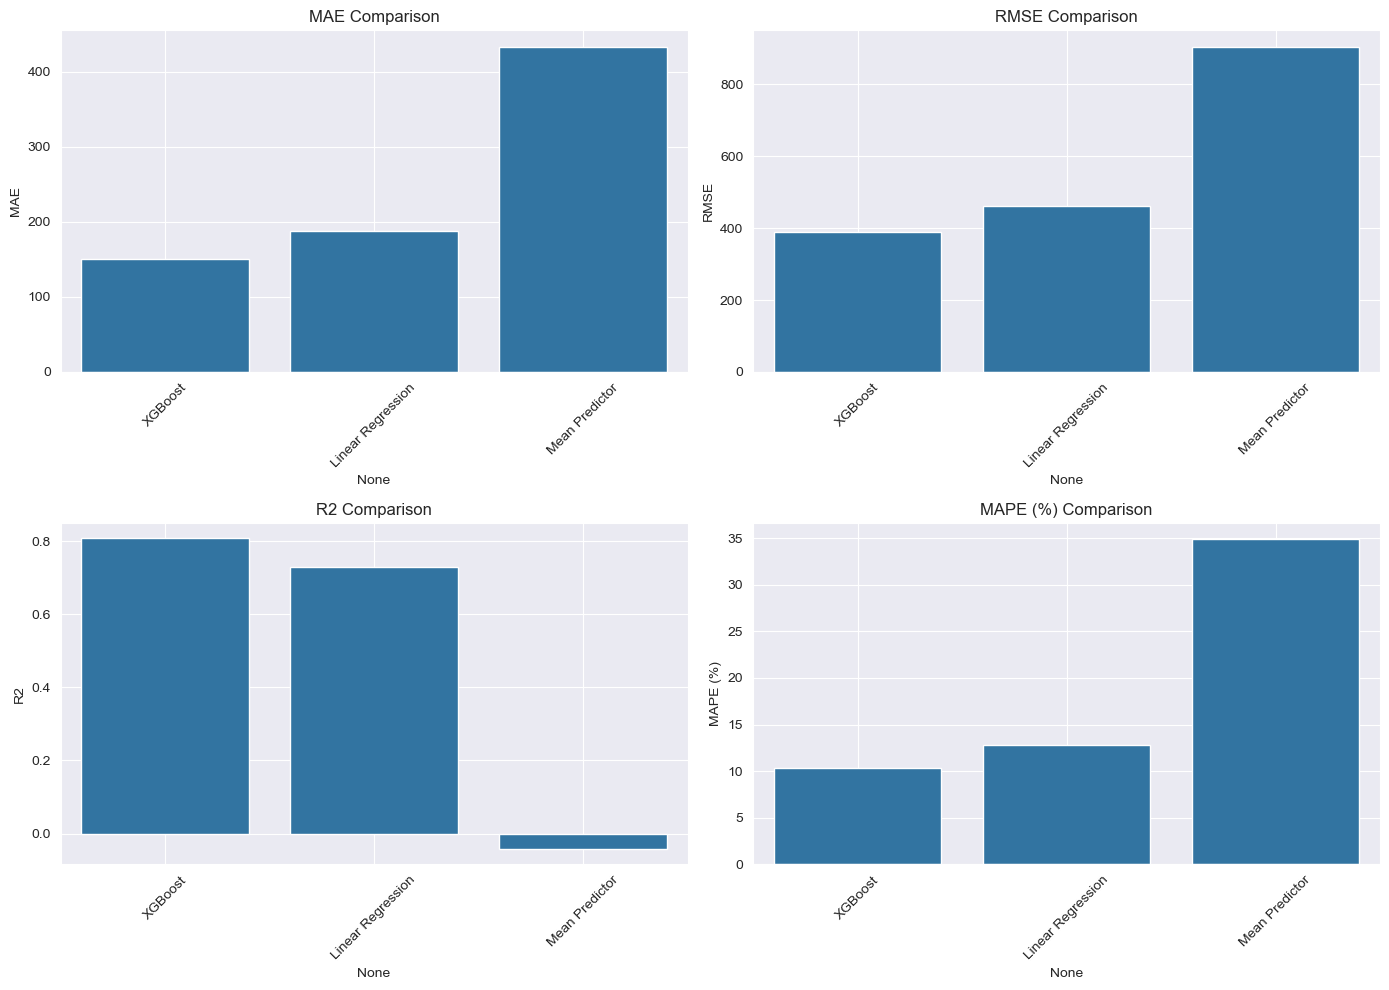



SUMMARY OF HYPOTHESIS TESTING

Research Question: How accurate can a XGBoost model predict campaign metrics based on outputs generated by the MINLP model?

Awareness Model (Clicks Prediction):
- RMSE: 21.11
- R²: 0.5997
- MAPE: 56.15%

Conversion Model (Impressions Prediction):
- RMSE: 389.27
- R²: 0.8072
- MAPE: 10.35%

Performance Improvement over Linear Regression:
- Awareness Model: 13.13% reduction in RMSE
- Conversion Model: 15.77% reduction in RMSE

Conclusion:
The hypothesis testing results are mixed. While some improvements are observed,
further investigation may be needed to conclusively reject the null hypothesis across all conditions.


In [7]:
# Function to find the dataset file
def find_dataset_file(base_paths=None, filename='cleaned_marketing_campaign_dataset.csv'):
    """
    Try to find the dataset file in various locations
    
    Parameters:
    -----------
    base_paths: list of str, optional
        List of base paths to search in
    filename: str
        Name of the dataset file
    
    Returns:
    --------
    file_path: str
        Path to the found dataset file
    """
    if base_paths is None:
        # Default paths to check
        base_paths = [
            '.',  # Current directory
            '..',  # Parent directory
            os.path.join('..', '..'),  # Grandparent directory
            os.path.expanduser('~'),  # Home directory
            os.path.join(os.path.expanduser('~'), 'Desktop'),  # Desktop
            os.path.join(os.path.expanduser('~'), 'Desktop', 'Thesis'),  # Thesis folder
            os.path.join(os.path.expanduser('~'), 'Desktop', 'Thesis', 'XGBoost'),  # Specific folder
            os.path.join(os.path.expanduser('~'), 'Desktop', 'Thesis', 'XGBoost', 'prototype')
        ]
    
    # Try case-insensitive matching
    lower_filename = filename.lower()
    
    # Search in all base paths
    for base_path in base_paths:
        try:
            # List all files in the directory
            for root, dirs, files in os.walk(base_path):
                for file in files:
                    if file.lower() == lower_filename:
                        file_path = os.path.join(root, file)
                        print(f"Found dataset at: {file_path}")
                        return file_path
        except Exception as e:
            print(f"Error searching in {base_path}: {e}")
    
    # If file not found in any of the specified locations
    file_path = input("Please enter the full path to the dataset file: ")
    if os.path.exists(file_path):
        return file_path
    else:
        raise FileNotFoundError(f"Could not find {filename} at the specified path")

# Function to create campaign segments based on media_cost
def create_campaign_segments(cost):
    if cost < 1:
        return 'micro-budget'
    elif cost < 10:
        return 'small'
    elif cost < 100:
        return 'medium'
    else:
        return 'large'

# Function to compare XGBoost with baseline models
def compare_models_with_baselines(data_path, campaign_type, xgb_model_path=None):
    """
    Compare XGBoost model with baseline models using cross-validation
    
    Parameters:
    -----------
    data_path: str
        Path to the cleaned dataset
    campaign_type: str
        'awareness' or 'conversion'
    xgb_model_path: str, optional
        Path to the trained XGBoost model. If None, uses default naming convention.
    
    Returns:
    --------
    results_df: pandas DataFrame
        DataFrame containing cross-validation results for all models
    """
    # Load the dataset
    print(f"Loading dataset from: {data_path}")
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully with {len(df)} rows")
    
    # Print column names for debugging
    print("Available columns:", df.columns.tolist())
    
    # Prepare features and target
    # Apply log transformation to media_cost if not already present
    if 'log_media_cost' not in df.columns:
        df['log_media_cost'] = np.log1p(df['media_cost_usd'])
    
    # Create campaign segments if not already present
    if 'campaign_segment' not in df.columns:
        df['campaign_segment'] = df['media_cost_usd'].apply(create_campaign_segments)
    
    # Create nonlinear features for both models
    df['log_media_cost_squared'] = df['log_media_cost'] ** 2
    df['log_duration'] = np.log1p(df['duration'])
    df['duration_squared'] = df['duration'] ** 2
    df['log_media_cost_x_duration'] = df['log_media_cost'] * df['duration']
    
    # Define all features to use
    feature_columns = [
        'log_media_cost', 
        'duration', 
        'ext_service_name', 
        'campaign_segment',
        'log_media_cost_squared',
        'log_duration',
        'duration_squared',
        'log_media_cost_x_duration'
    ]
    
    # Define target based on campaign type
    if campaign_type == 'awareness':
        target = 'clicks'
    elif campaign_type == 'conversion':
        target = 'impressions'
    else:
        raise ValueError("campaign_type must be 'awareness' or 'conversion'")
    
    # Apply log transformation to target
    df['log_target'] = np.log1p(df[target])
    
    # Select features and target
    X = df[feature_columns]
    y = df['log_target']  # Use log-transformed target
    y_original = df[target]  # Keep original for back-transformation
    
    # Define categorical features
    categorical_features = ['ext_service_name', 'campaign_segment']
    
    # Define preprocessing for scikit-learn models
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), [col for col in feature_columns if col not in categorical_features]),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Define models to compare
    linear_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    mean_predictor = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DummyRegressor(strategy='mean'))
    ])
    
    models = {
        'XGBoost': None,  # This will be loaded below
        'Linear Regression': linear_pipeline,
        'Mean Predictor': mean_predictor
    }
    
    # Load the trained XGBoost model if provided
    if xgb_model_path is None:
        xgb_model_path = f"xgboost_{campaign_type}_best_model.pkl"
    
    # For this test, create a new XGBoost model since we might not have the saved one
    print(f"Creating a new XGBoost model for {campaign_type} for comparison")
    
    # Create a new XGBoost model
    xgb_preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), [col for col in feature_columns if col not in categorical_features]),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Use the parameters from your best models
    if campaign_type == 'awareness':
        xgb_model = Pipeline([
            ('preprocessor', xgb_preprocessor),
            ('regressor', xgb.XGBRegressor(
                n_estimators=214,
                max_depth=8,
                learning_rate=0.025,
                subsample=0.926,
                colsample_bytree=0.946,
                min_child_weight=2,
                gamma=0.486,
                reg_alpha=0.449,
                reg_lambda=4.218,
                random_state=42
            ))
        ])
    else:  # conversion
        xgb_model = Pipeline([
            ('preprocessor', xgb_preprocessor),
            ('regressor', xgb.XGBRegressor(
                n_estimators=251,
                max_depth=10,
                learning_rate=0.031,
                subsample=0.949,
                colsample_bytree=0.635,
                min_child_weight=2,
                gamma=0.193,
                reg_alpha=0.255,
                reg_lambda=3.061,
                random_state=42
            ))
        ])
    
    models['XGBoost'] = xgb_model
    
    # Create a dummy model_data for consistency
    model_data = {'use_log_target': True}
    
    # Define cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Store results
    cv_results = {}
    all_errors = {}
    
    # Perform cross-validation for each model
    for name, model in models.items():
        print(f"Evaluating {name}...")
        
        # For untrained models, use cross_validate
        scores = cross_validate(
            model, 
            X, y, 
            cv=cv, 
            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
            return_estimator=True
        )
        
        # Collect predictions for each fold
        y_preds = []
        y_trues = []
        
        for i, (_, test_idx) in enumerate(cv.split(X)):
            trained_model = scores['estimator'][i]
            X_test_fold = X.iloc[test_idx]
            
            # Get predictions
            y_pred_log = trained_model.predict(X_test_fold)
            y_true = y_original.iloc[test_idx].values
            
            # Convert log predictions back to original scale
            y_pred = np.expm1(y_pred_log)
            
            y_preds.extend(y_pred)
            y_trues.extend(y_true)
        
        # Calculate metrics
        mae = mean_absolute_error(y_trues, y_preds)
        rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
        r2 = r2_score(y_trues, y_preds)
        
        # Calculate MAPE (handling zeros)
        y_true_non_zero = np.array(y_trues)
        y_pred_non_zero = np.array(y_preds)
        mask = y_true_non_zero != 0
        mape = mean_absolute_percentage_error(y_true_non_zero[mask], y_pred_non_zero[mask]) * 100
        
        cv_results[name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE (%)': mape
        }
        
        all_errors[name] = np.abs(np.array(y_trues) - np.array(y_preds))
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(cv_results).T
    
    # Display results
    print(f"\nCross-Validation Results for {campaign_type.capitalize()} Model:")
    print(results_df)
    
    # Perform paired t-tests to compare models
    print("\nStatistical Significance Testing:")
    
    # XGBoost vs Mean Predictor
    t_stat_xgb_vs_mean, p_val_xgb_vs_mean = stats.ttest_rel(
        all_errors['XGBoost'], 
        all_errors['Mean Predictor']
    )
    
    # XGBoost vs Linear Regression
    t_stat_xgb_vs_linear, p_val_xgb_vs_linear = stats.ttest_rel(
        all_errors['XGBoost'], 
        all_errors['Linear Regression']
    )
    
    print(f"XGBoost vs Mean Predictor: t-statistic={t_stat_xgb_vs_mean:.4f}, p-value={p_val_xgb_vs_mean:.6f}")
    print(f"XGBoost vs Linear Regression: t-statistic={t_stat_xgb_vs_linear:.4f}, p-value={p_val_xgb_vs_linear:.6f}")
    
    # Determine hypothesis test results
    alpha = 0.05
    
    if p_val_xgb_vs_mean < alpha and p_val_xgb_vs_linear < alpha:
        if np.mean(all_errors['XGBoost']) < np.mean(all_errors['Mean Predictor']) and \
           np.mean(all_errors['XGBoost']) < np.mean(all_errors['Linear Regression']):
            print("\nHypothesis Test Result: Reject H₀ - XGBoost performs significantly better than baseline models")
        else:
            print("\nHypothesis Test Result: Reject H₀ - XGBoost performs significantly different from baseline models")
    else:
        print("\nHypothesis Test Result: Fail to reject H₀ - XGBoost does not perform significantly better than baseline models")
    
    # Plot comparison of model performance
    plt.figure(figsize=(14, 10))
    
    metrics = ['MAE', 'RMSE', 'R2', 'MAPE (%)']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        sns.barplot(x=results_df.index, y=results_df[metric])
        plt.title(f'{metric} Comparison')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{campaign_type}_model_comparison.png')
    plt.show()
    
    return results_df, all_errors

# Function to run tests for both models
def run_hypothesis_tests():
    """
    Run hypothesis tests for both awareness and conversion models
    """
    # Try to find the dataset file
    try:
        data_path = find_dataset_file()
    except FileNotFoundError:
        print("Could not find the dataset file automatically.")
        data_path = input("Please enter the full path to the dataset file: ")
    
    print("="*80)
    print("TESTING HYPOTHESIS FOR AWARENESS MODEL (CLICKS PREDICTION)")
    print("="*80)
    awareness_results, awareness_errors = compare_models_with_baselines(
        data_path=data_path,
        campaign_type='awareness'
    )
    
    print("\n\n" + "="*80)
    print("TESTING HYPOTHESIS FOR CONVERSION MODEL (IMPRESSIONS PREDICTION)")
    print("="*80)
    conversion_results, conversion_errors = compare_models_with_baselines(
        data_path=data_path,
        campaign_type='conversion'
    )
    
    # Summarize overall findings
    print("\n\n" + "="*80)
    print("SUMMARY OF HYPOTHESIS TESTING")
    print("="*80)
    
    print("\nResearch Question: How accurate can a XGBoost model predict campaign metrics based on outputs generated by the MINLP model?")
    
    print("\nAwareness Model (Clicks Prediction):")
    print(f"- RMSE: {awareness_results.loc['XGBoost', 'RMSE']:.2f}")
    print(f"- R²: {awareness_results.loc['XGBoost', 'R2']:.4f}")
    print(f"- MAPE: {awareness_results.loc['XGBoost', 'MAPE (%)']:.2f}%")
    
    print("\nConversion Model (Impressions Prediction):")
    print(f"- RMSE: {conversion_results.loc['XGBoost', 'RMSE']:.2f}")
    print(f"- R²: {conversion_results.loc['XGBoost', 'R2']:.4f}")
    print(f"- MAPE: {conversion_results.loc['XGBoost', 'MAPE (%)']:.2f}%")
    
    # Calculate improvement percentages
    awareness_rmse_improvement = (awareness_results.loc['Linear Regression', 'RMSE'] - 
                                awareness_results.loc['XGBoost', 'RMSE']) / awareness_results.loc['Linear Regression', 'RMSE'] * 100
    
    conversion_rmse_improvement = (conversion_results.loc['Linear Regression', 'RMSE'] - 
                                conversion_results.loc['XGBoost', 'RMSE']) / conversion_results.loc['Linear Regression', 'RMSE'] * 100
    
    print("\nPerformance Improvement over Linear Regression:")
    print(f"- Awareness Model: {awareness_rmse_improvement:.2f}% reduction in RMSE")
    print(f"- Conversion Model: {conversion_rmse_improvement:.2f}% reduction in RMSE")


# Run the hypothesis tests
if __name__ == "__main__":
    run_hypothesis_tests()